In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration

# 2 body problem

SimulationConfig(N_particles=2, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=1e-10, integrator=0, acceleration_scheme=0, external_accelerations=())
SimulationParams(G=1, t_end=1, Plummer_a=7)


/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


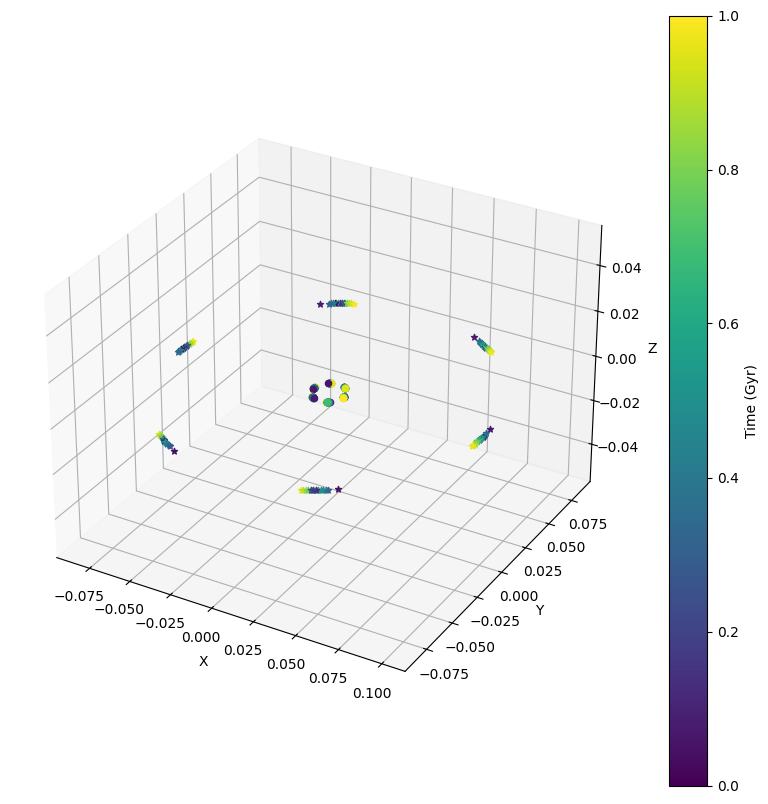

In [2]:
# Define the 
config = SimulationConfig(N_particles=2, return_snapshots=True, num_snapshots=100, num_timesteps=1000, external_accelerations=(), softening=1e-10) #default values

params = SimulationParams(t_end = 1, G=1) #default values

print(config)
print(params)

mass1 = 10
mass2 = 1

pos, vel, mass = ic_two_body(mass1, mass2, rp=0.1, e=0., config=config, params=params)
mass = jnp.array([mass1, mass2])
initial_state = construct_initial_state(pos, vel)

snapshots= time_integration(initial_state, mass, config, params)
# check the energy conservation, remove the last snapshot:

fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

# Normalize the times to the range [0, 1] for colormap
norm_times = (snapshots.times - snapshots.times.min()) / (snapshots.times.max() - snapshots.times.min())

# Generate colors using a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(norm_times)
for i in range(0, len(snapshots.states), 1):
    sc = ax.scatter(snapshots.states[i, 0, 0, 0], snapshots.states[i, 0, 0, 1], snapshots.states[i, 0, 0, 2], color=colors[i], )
    ax.scatter(snapshots.states[i, 1, 0, 0], snapshots.states[i, 1, 0, 1], snapshots.states[i, 1, 0, 2], color=colors[i],  marker='*', )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cbar = plt.colorbar(sc)
cbar.set_label('Time (Gyr)')



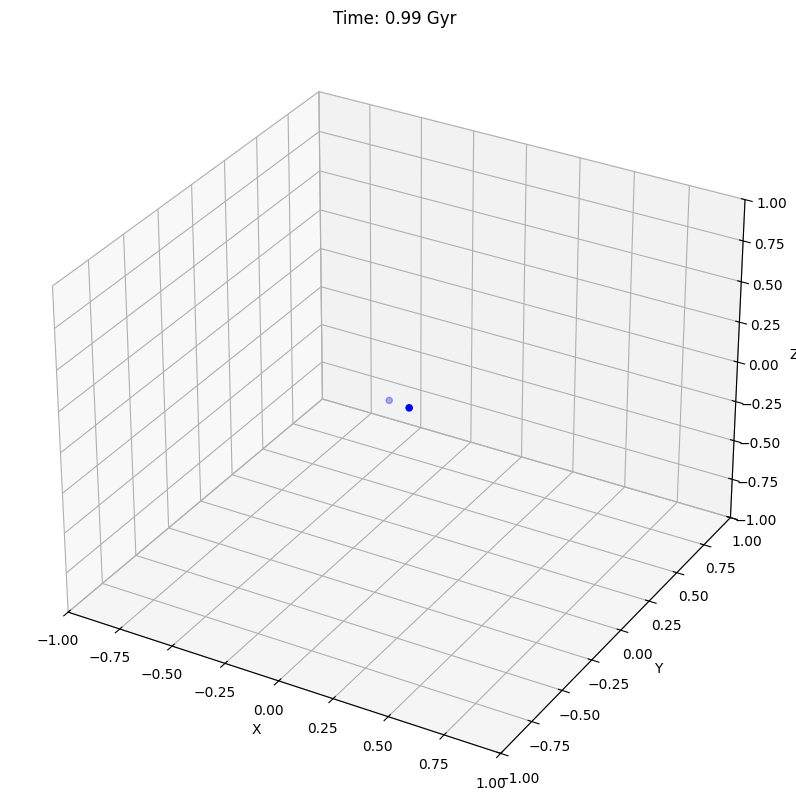

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

def create_gif_from_snapshots(snapshots, filename='simulation_2body.gif'):
    # Create a figure for plotting
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the scatter plot
    scatter1 = ax.scatter([], [], [], c='b')
    scatter2 = ax.scatter([], [], [], c='r', marker='*')

    def init():
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return scatter1, scatter2

    def update(frame):
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)
        ax.set_title(f'Time: {snapshots.times[frame]:.2f} Gyr')
        scatter1 = ax.scatter(snapshots.states[frame, :, 0, 0], snapshots.states[frame, :, 0, 1], snapshots.states[frame, :, 0, 2], c='b')
        return scatter1, scatter2

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(0, len(snapshots.states), 1), init_func=init, blit=False)

    # Save the animation as a GIF
    anim.save(filename, writer=PillowWriter(fps=10))

# Example usage
# Assuming snapshots is available
create_gif_from_snapshots(snapshots)

(-1.0, 1.0)

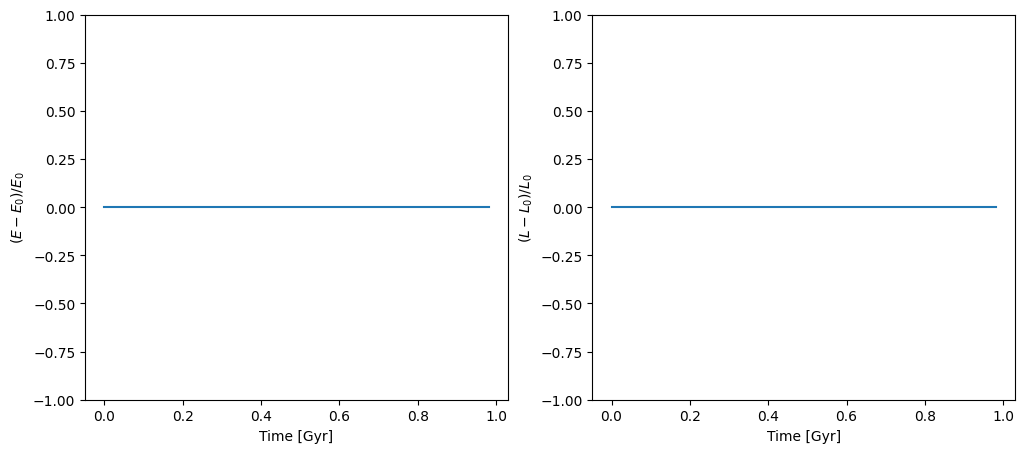

In [4]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
# check the energy conservation, remove the last snapshot:
Delta_E = ((snapshots.total_energy - snapshots.total_energy[0])/snapshots.total_energy[0])[:-1]
ax.plot(snapshots.times[:-1], Delta_E, )
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(E - E_0)/E_0$')
ax.set_ylim(-1, 1)

ax = fig.add_subplot(122)
Delta_AngMom = ((snapshots.angular_momentum - snapshots.angular_momentum[0])/snapshots.angular_momentum[0])[:-1]
ax.plot(snapshots.times[:-1], Delta_AngMom[:, 2], )
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(L - L_0)/L_0$')
ax.set_ylim(-1, 1)